In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
from os import listdir
import pathlib
from random import randint
import numpy as np
from numpy import asarray
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import tensorflow_addons as tfa
from keras.utils import load_img,img_to_array
from keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import MaxPooling2D,Dropout,Dense,Input,Conv2D,Flatten,Conv2DTranspose
from keras.layers import GlobalAveragePooling2D,MaxPool2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

In [4]:
folder = 'Dataset'
folder_path = pathlib.Path(folder)

In [5]:
for file in listdir(folder):
    print(file)

AD
CN
MCI


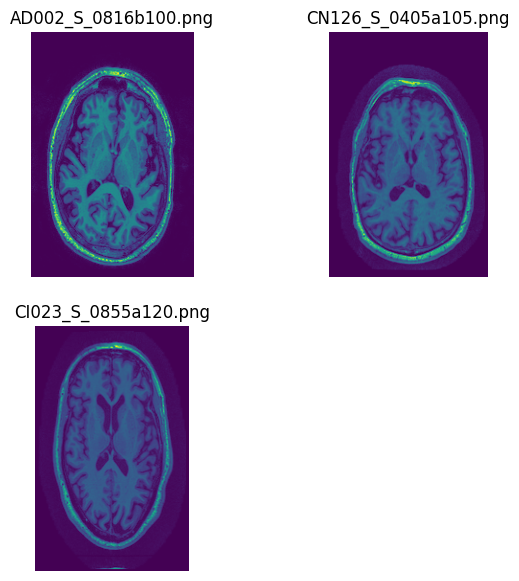

In [6]:
plt.figure(figsize=(7,7),)
j =0
for file in listdir(folder):
    i =0
    for image in listdir(folder + '/'+file):
        if i ==1:
            break;
        img = imread(folder +'/' + file + '/' + image)
        ax = plt.subplot(2,2,j+1)
        plt.imshow(img)
        plt.title(image)
        plt.axis('off')
        j = j+1
        i = i +1
plt.show()

In [7]:
# counting the number of images in each category
for file in listdir(folder):
    i =0
    for image in listdir(folder + '/'+file):
        i = i +1
    print(file , i)

AD 1124
CN 1440
MCI 2590


In [8]:
# Creating the image datagenerator to have more samples
IMG_SIZE = 256
DIM = (IMG_SIZE, IMG_SIZE)

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

In [9]:
train_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM,
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)
train_data_gen = train_generator.flow_from_directory(directory=folder, target_size=DIM, batch_size=6500, shuffle=False)

Found 5154 images belonging to 3 classes.


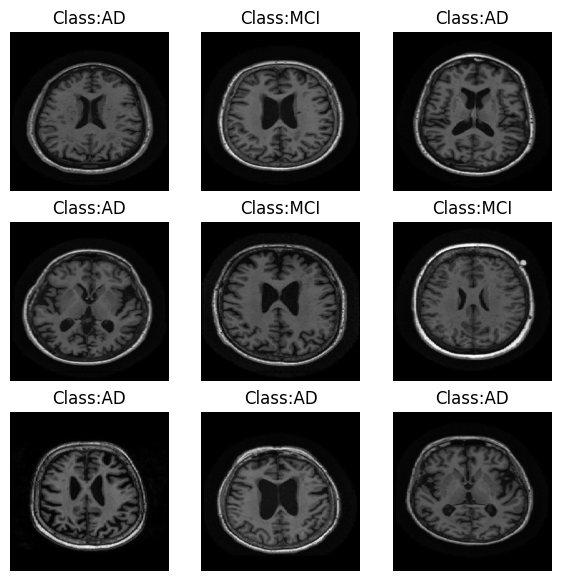

In [38]:
CLASSES = list(train_data_gen.class_indices.keys())

def show_images(generator,y_pred=None):
    # get image lables
    labels =dict(zip([0,1,2], CLASSES))

    # get a batch of images
    x,y = generator.next()

    # display a grid of 9 images
    plt.figure(figsize=(7, 7))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 5154)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))

# Display Train Images
show_images(train_data_gen)

In [39]:
train_data, train_labels = train_data_gen.next()

In [40]:
train_data.shape, train_labels.shape

((5154, 256, 256, 3), (5154, 3))

In [41]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

print(train_data.shape, train_labels.shape)

(7770, 196608) (7770, 3)


In [42]:
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(7770, 256, 256, 3) (7770, 3)


In [43]:
train_data, test_data, train_labels,test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

train_data, val_data, train_labels,val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [44]:
# Defining convolutional blocks
def conv_block(filters, act='relu'):

    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())

    return block

In [45]:
# defining dense blocks
def dense_block(units, dropout_rate, act='relu'):
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))

    return block

In [46]:
IMAGE_SIZE = [256,256]
act = 'relu'

In [47]:
model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')
    ], name = "cnn_model")

In [48]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_292 (Conv2D)         (None, 256, 256, 16)      448       
                                                                 
 conv2d_293 (Conv2D)         (None, 256, 256, 16)      2320      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 sequential_7 (Sequential)   (None, 64, 64, 32)        14016     
                                                                 
 sequential_8 (Sequential)   (None, 32, 32, 64)        55680     
                                                                 
 sequential_9 (Sequential)   (None, 16, 16, 128)       221952    
                                                         

In [23]:
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [24]:
CALLBACKS = [
    EarlyStopping(monitor='accuracy', min_delta=0.01, patience=5, mode='max')
]

In [25]:
EPOCHS = 20

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS,callbacks=CALLBACKS)

Epoch 1/20


ValueError: in user code:

    File "/Users/vladaefremenko/Desktop/Лабораторные/Proj/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Users/vladaefremenko/Desktop/Лабораторные/Proj/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/vladaefremenko/Desktop/Лабораторные/Proj/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Users/vladaefremenko/Desktop/Лабораторные/Proj/lib/python3.11/site-packages/keras/engine/training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/vladaefremenko/Desktop/Лабораторные/Proj/lib/python3.11/site-packages/keras/engine/training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "/Users/vladaefremenko/Desktop/Лабораторные/Proj/lib/python3.11/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/vladaefremenko/Desktop/Лабораторные/Proj/lib/python3.11/site-packages/keras/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/vladaefremenko/Desktop/Лабораторные/Proj/lib/python3.11/site-packages/keras/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/vladaefremenko/Desktop/Лабораторные/Proj/lib/python3.11/site-packages/keras/losses.py", line 1984, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/Users/vladaefremenko/Desktop/Лабораторные/Proj/lib/python3.11/site-packages/keras/backend.py", line 5559, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 3) and (None, 4) are incompatible


In [57]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

inception = InceptionV3(input_shape=(256,256,3),include_top=False,weights ='imagenet')

In [58]:
for layer in inception.layers:
    layer.trainable = False

In [59]:
inception_model = Sequential([
        inception,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')
    ], name = "inception_cnn_model")

In [60]:
inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 dropout_25 (Dropout)        (None, 6, 6, 2048)        0         
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_499 (Ba  (None, 2048)             8192      
 tchNormalization)                                               
                                                                 
 dense_23 (Dense)            (None, 512)       

In [61]:
INCEPT_CALLBACKS = [
    ModelCheckpoint(filepath='incpt_model_checkpoint.h5', save_best_only=True),
    EarlyStopping(patience=3)
]

In [62]:
incept_history = inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=20,callbacks= INCEPT_CALLBACKS)

Epoch 1/20


ValueError: in user code:

    File "/Users/vladaefremenko/Desktop/Лабораторные/Proj/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Users/vladaefremenko/Desktop/Лабораторные/Proj/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/vladaefremenko/Desktop/Лабораторные/Proj/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Users/vladaefremenko/Desktop/Лабораторные/Proj/lib/python3.11/site-packages/keras/engine/training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/vladaefremenko/Desktop/Лабораторные/Proj/lib/python3.11/site-packages/keras/engine/training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "/Users/vladaefremenko/Desktop/Лабораторные/Proj/lib/python3.11/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/vladaefremenko/Desktop/Лабораторные/Proj/lib/python3.11/site-packages/keras/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/vladaefremenko/Desktop/Лабораторные/Proj/lib/python3.11/site-packages/keras/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/vladaefremenko/Desktop/Лабораторные/Proj/lib/python3.11/site-packages/keras/losses.py", line 1984, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/Users/vladaefremenko/Desktop/Лабораторные/Proj/lib/python3.11/site-packages/keras/backend.py", line 5559, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 3) and (None, 4) are incompatible
